21:19:12 - cmdstanpy - INFO - Chain [1] start processing
21:19:12 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Tuan Anh\AppData\Local\Temp\ipykernel_20672\2543965026.py:46: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_day['Price'] = data_day['Price'].fillna(method='ffill')


Epoch [1/30], Loss: 0.000986
Epoch [2/30], Loss: 0.000640
Epoch [3/30], Loss: 0.000350
Epoch [4/30], Loss: 0.000708
Epoch [5/30], Loss: 0.000637
Epoch [6/30], Loss: 0.000247
Epoch [7/30], Loss: 0.000269
Epoch [8/30], Loss: 0.000501
Epoch [9/30], Loss: 0.000301
Epoch [10/30], Loss: 0.000318
Epoch [11/30], Loss: 0.000476
Epoch [12/30], Loss: 0.000295
Epoch [13/30], Loss: 0.000421
Epoch [14/30], Loss: 0.000460
Epoch [15/30], Loss: 0.000527
Epoch [16/30], Loss: 0.000284
Epoch [17/30], Loss: 0.000164
Epoch [18/30], Loss: 0.000173
Epoch [19/30], Loss: 0.000269
Epoch [20/30], Loss: 0.000342
Epoch [21/30], Loss: 0.000221
Epoch [22/30], Loss: 0.000295
Epoch [23/30], Loss: 0.000297
Epoch [24/30], Loss: 0.000396
Epoch [25/30], Loss: 0.000177
Epoch [26/30], Loss: 0.000206
Epoch [27/30], Loss: 0.000190
Epoch [28/30], Loss: 0.000185
Epoch [29/30], Loss: 0.000371
Epoch [30/30], Loss: 0.000192
Dữ liệu đầy đủ từ 1/1/2015 đến 1/5/2028 đã được lưu vào 'SP500_Full_Predictions_2015_2028.csv'


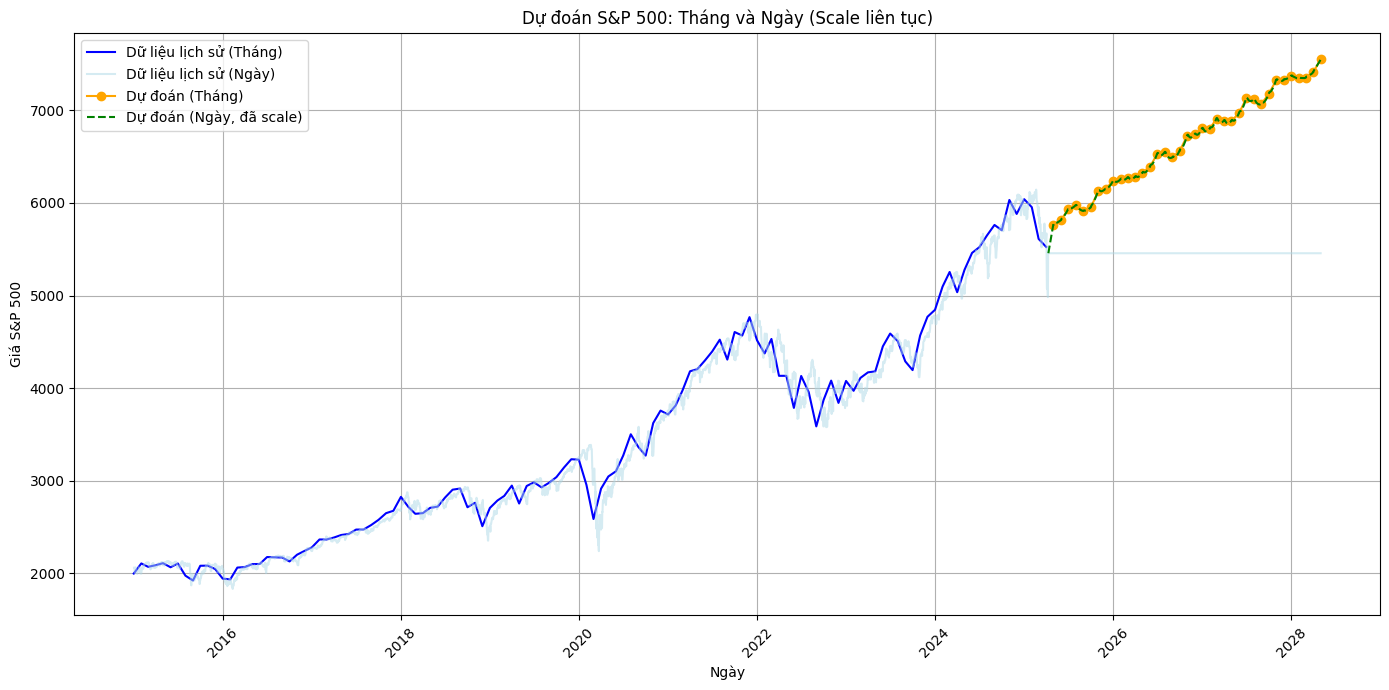

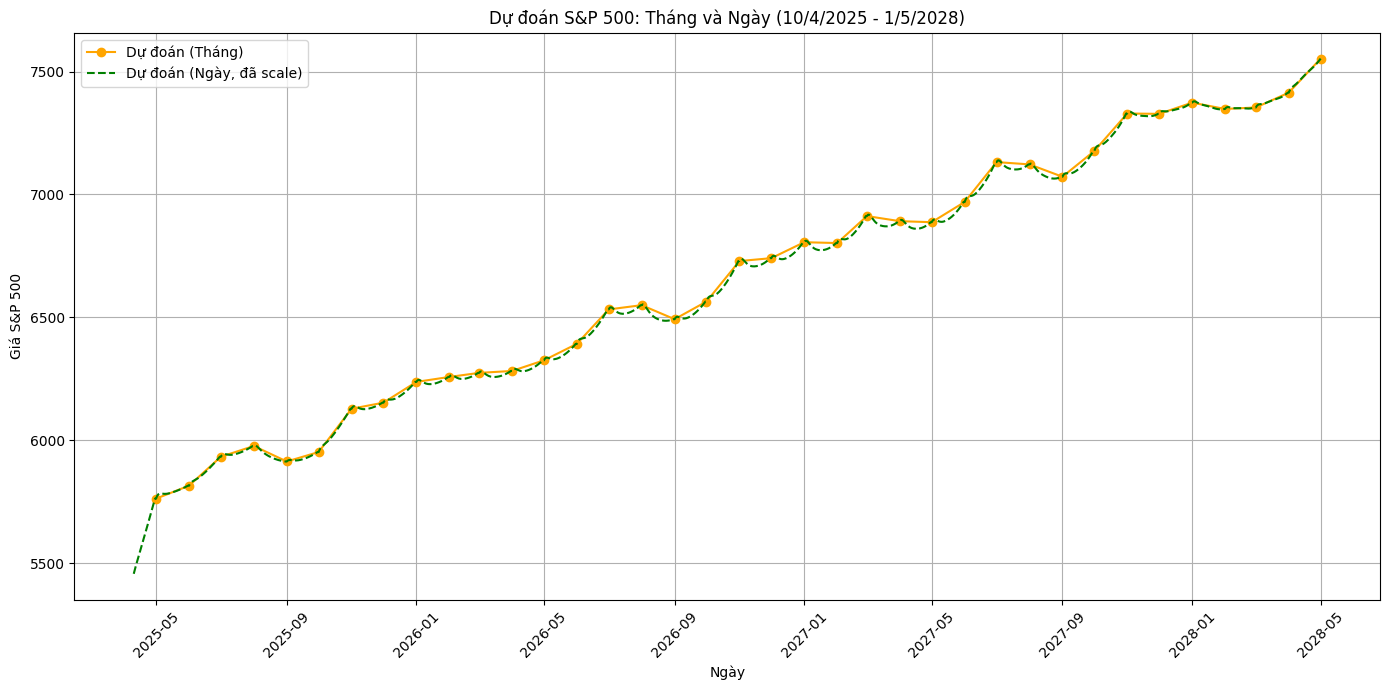

Biểu đồ tổng quan đã được lưu vào 'SP500_Prediction_Chart_Full.png'
Biểu đồ chi tiết (10/4/2025 - 1/5/2028) đã được lưu vào 'SP500_Prediction_Chart_Detail_2025_2028.png'


In [4]:
import pandas as pd
import numpy as np
from prophet import Prophet
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 1. Đọc và cắt dữ liệu tháng (S&P500_MONTH.csv) đến 9/4/2025
data_month = pd.read_csv('S&P500_MONTH.csv')
data_month['Date'] = pd.to_datetime(data_month['Date'])
data_month['Price'] = data_month['Price'].astype(str).str.replace(',', '').astype(float)
data_month = data_month[data_month['Date'] <= pd.to_datetime('2025-04-09')]
data_month = data_month[['Date', 'Price']]
data_month.columns = ['ds', 'y']

# 2. Huấn luyện mô hình Prophet để dự đoán giá S&P 500 theo tháng
model_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model_prophet.fit(data_month)

# Tạo khung thời gian tương lai (từ 1/4/2024 đến 1/5/2028)
future_dates = pd.date_range(start='2024-04-01', end='2028-05-01', freq='MS')
future_df = pd.DataFrame({'ds': future_dates})
forecast = model_prophet.predict(future_df)
predicted_monthly = forecast[['ds', 'yhat']]
predicted_monthly.columns = ['Date', 'Predicted_Price']

# 3. Đọc và cắt dữ liệu ngày (S&P500_DAY.csv) đến 9/4/2025
data_day = pd.read_csv('S&P500_DAY.csv')
data_day['Date'] = pd.to_datetime(data_day['Date'])
data_day['Price'] = data_day['Price'].astype(str).str.replace(',', '').astype(float)
data_day = data_day[data_day['Date'] <= pd.to_datetime('2025-04-09')]

# Tạo khung thời gian ngày từ 1/1/2015 đến 1/5/2028, điền giá trị thiếu
all_dates = pd.date_range(start='2015-01-01', end='2028-05-01', freq='D')
data_day = data_day.set_index('Date').reindex(all_dates).reset_index()
data_day = data_day.rename(columns={'index': 'Date'})
data_day['Price'] = data_day['Price'].ffill()

# Lấy cột 'Price' để huấn luyện
data_day = data_day[['Date', 'Price']]

# Kiểm tra và xử lý NaN
if data_day['Price'].isna().any():
    data_day['Price'] = data_day['Price'].fillna(method='ffill')

# Chuẩn hóa dữ liệu ngày
scaler = MinMaxScaler()
scaled_data_day = scaler.fit_transform(data_day['Price'].values.reshape(-1, 1))
if np.any(np.isnan(scaled_data_day)) or np.any(np.isinf(scaled_data_day)):
    scaled_data_day = np.nan_to_num(scaled_data_day, nan=0.0, posinf=0.0, neginf=0.0)

# 4. Chuẩn bị dữ liệu cho LSTM với time_step = 300
time_step = 300
def create_lstm_data(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

X, y = create_lstm_data(scaled_data_day, time_step)

# Toàn bộ dữ liệu từ 1/1/2015 đến 9/4/2025 dùng để huấn luyện
X_train_tensor = torch.FloatTensor(X).unsqueeze(-1)
y_train_tensor = torch.FloatTensor(y).reshape(-1, 1)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 5. Định nghĩa mô hình LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Huấn luyện LSTM
model_lstm = LSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_lstm = model_lstm.to(device)

num_epochs = 30
for epoch in range(num_epochs):
    model_lstm.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model_lstm(X_batch)
        loss = criterion(outputs, y_batch)
        optimizer.zero_grad()
        torch.nn.utils.clip_grad_norm_(model_lstm.parameters(), max_norm=1.0)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

# 6. Dự đoán từ 10/4/2025 đến 1/5/2028 với scale liên tục
# Khởi tạo dữ liệu ban đầu từ dữ liệu thực tế (1/1/2015 - 9/4/2025)
historical_data = scaled_data_day.flatten().tolist()

# Tạo khung thời gian dự đoán từ 10/4/2025 đến 1/5/2028
future_dates_daily = pd.date_range(start='2025-04-10', end='2028-05-01', freq='D')
daily_df = pd.DataFrame({'Date': future_dates_daily})
daily_df = daily_df.merge(predicted_monthly, on='Date', how='left')

# Dự đoán từng đoạn và scale liên tục
model_lstm.eval()
predictions_daily = []
current_window = historical_data[-time_step:]

# Lưu giá trị đã scale tại ngày trước đó để đảm bảo tính liên tục
last_scaled_price = scaler.inverse_transform([[historical_data[-1]]])[0, 0]

for i in range(len(predicted_monthly) - 1):
    start_date = max(predicted_monthly['Date'].iloc[i], pd.to_datetime('2025-04-10'))
    end_date = predicted_monthly['Date'].iloc[i + 1] - pd.Timedelta(days=1)
    next_month_start = predicted_monthly['Date'].iloc[i + 1]
    if i == len(predicted_monthly) - 2:
        end_date = pd.to_datetime('2028-05-01')
    if start_date > end_date:
        continue
    segment_dates = pd.date_range(start=start_date, end=end_date, freq='D')
    n_days = len(segment_dates)
    if n_days == 0:
        continue
    segment_predictions = []
    current_window_tensor = torch.FloatTensor(current_window[-time_step:]).unsqueeze(0).unsqueeze(-1).to(device)
    with torch.no_grad():
        window = current_window_tensor
        for _ in range(n_days):
            pred = model_lstm(window).cpu().numpy()[0, 0]
            segment_predictions.append(pred)
            new_window = np.append(window.cpu().numpy()[0, 1:, 0], pred)
            window = torch.FloatTensor(new_window).unsqueeze(0).unsqueeze(-1).to(device)

    segment_predictions = np.array(segment_predictions).reshape(-1, 1)
    segment_predictions_rescaled = scaler.inverse_transform(segment_predictions)

    # Scale giá ngày với nội suy tuyến tính để đảm bảo liên tục
    if end_date >= next_month_start - pd.Timedelta(days=1):
        monthly_price_next = predicted_monthly['Predicted_Price'].iloc[i + 1]
        daily_price_at_end = segment_predictions_rescaled[-1, 0]
        daily_price_at_start = segment_predictions_rescaled[0, 0]
        adjustment_at_start = last_scaled_price - daily_price_at_start
        adjustment_at_end = monthly_price_next - daily_price_at_end
        segment_length = n_days
        adjustments = np.linspace(adjustment_at_start, adjustment_at_end, segment_length)
        segment_predictions_scaled = segment_predictions_rescaled + adjustments.reshape(-1, 1)
        last_scaled_price = segment_predictions_scaled[-1, 0]
    else:
        adjustment_at_start = last_scaled_price - daily_price_at_start
        segment_predictions_scaled = segment_predictions_rescaled + adjustment_at_start
        last_scaled_price = segment_predictions_scaled[-1, 0]

    # Cập nhật current_window với giá đã scale
    scaled_segment = scaler.transform(segment_predictions_scaled.reshape(-1, 1)).flatten()
    current_window.extend(scaled_segment.tolist())
    predictions_daily.extend(segment_predictions_scaled.flatten())

# Tạo DataFrame kết hợp dữ liệu lịch sử và dự đoán
combined_data = pd.concat([data_day[data_day['Date'] <= pd.to_datetime('2025-04-10')], 
                          pd.DataFrame({'Date': future_dates_daily, 'Price': predictions_daily})])
combined_data = combined_data[(combined_data['Date'] >= pd.to_datetime('2015-01-01')) & 
                              (combined_data['Date'] <= pd.to_datetime('2028-05-01'))]
combined_data = combined_data.reset_index(drop=True)

combined_data = combined_data[~((combined_data['Date'] >= pd.to_datetime('2025-04-11')) & 
                                (combined_data['Date'] <= pd.to_datetime('2025-04-10')))]

# Lưu kết quả vào file CSV
combined_data.to_csv('SP500_Full_Predictions_2015_2028.csv', index=False)
print("Dữ liệu đầy đủ từ 1/1/2015 đến 1/5/2028 đã được lưu vào 'SP500_Full_Predictions_2015_2028.csv'")

# Biểu đồ tổng quan từ 1/1/2015 đến 1/5/2028
plt.figure(figsize=(14, 7))
plt.plot(data_month['ds'], data_month['y'], label='Dữ liệu lịch sử (Tháng)', color='blue')
plt.plot(data_day['Date'], data_day['Price'], label='Dữ liệu lịch sử (Ngày)', color='lightblue', alpha=0.5)

# Chỉ vẽ giá dự đoán tháng từ 10/4/2025 trở đi
predicted_monthly_filtered = predicted_monthly[predicted_monthly['Date'] >= pd.to_datetime('2025-04-10')]
plt.plot(predicted_monthly_filtered['Date'], predicted_monthly_filtered['Predicted_Price'], label='Dự đoán (Tháng)', color='orange', marker='o')

plt.plot(combined_data[combined_data['Date'] >= pd.to_datetime('2025-04-10')]['Date'], 
         combined_data[combined_data['Date'] >= pd.to_datetime('2025-04-10')]['Price'], 
         label='Dự đoán (Ngày, đã scale)', color='green', linestyle='--')
plt.title('Dự đoán S&P 500: Tháng và Ngày (Scale liên tục)')
plt.xlabel('Ngày')
plt.ylabel('Giá S&P 500')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('SP500_Prediction_Chart_Full.png')
plt.show()
plt.close()

# Biểu đồ chi tiết từ 10/4/2025 đến 1/5/2028
mask_detail = (combined_data['Date'] >= pd.to_datetime('2025-04-10')) & (combined_data['Date'] <= pd.to_datetime('2028-05-01'))
combined_data_detail = combined_data[mask_detail]
month_df_detail = predicted_monthly[
    (predicted_monthly['Date'] >= pd.to_datetime('2025-04-10')) & 
    (predicted_monthly['Date'] <= pd.to_datetime('2028-05-01'))
]

plt.figure(figsize=(14, 7))
plt.plot(month_df_detail['Date'], month_df_detail['Predicted_Price'], label='Dự đoán (Tháng)', color='orange', marker='o')
plt.plot(combined_data_detail['Date'], combined_data_detail['Price'], label='Dự đoán (Ngày, đã scale)', color='green', linestyle='--')
plt.title('Dự đoán S&P 500: Tháng và Ngày (10/4/2025 - 1/5/2028)')
plt.xlabel('Ngày')
plt.ylabel('Giá S&P 500')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('SP500_Prediction_Chart_Detail_2025_2028.png')
plt.show()
plt.close()

print("Biểu đồ tổng quan đã được lưu vào 'SP500_Prediction_Chart_Full.png'")
print("Biểu đồ chi tiết (10/4/2025 - 1/5/2028) đã được lưu vào 'SP500_Prediction_Chart_Detail_2025_2028.png'")

20:58:30 - cmdstanpy - INFO - Chain [1] start processing
20:58:30 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Tuan Anh\AppData\Local\Temp\ipykernel_20672\3151083447.py:44: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_day['Lần cuối'] = data_day['Lần cuối'].fillna(method='ffill')


Epoch [1/30], Loss: 0.002019
Epoch [2/30], Loss: 0.000787
Epoch [3/30], Loss: 0.001393
Epoch [4/30], Loss: 0.001061
Epoch [5/30], Loss: 0.000606
Epoch [6/30], Loss: 0.000671
Epoch [7/30], Loss: 0.000444
Epoch [8/30], Loss: 0.000883
Epoch [9/30], Loss: 0.000610
Epoch [10/30], Loss: 0.000406
Epoch [11/30], Loss: 0.000576
Epoch [12/30], Loss: 0.000452
Epoch [13/30], Loss: 0.000534
Epoch [14/30], Loss: 0.000444
Epoch [15/30], Loss: 0.000287
Epoch [16/30], Loss: 0.000327
Epoch [17/30], Loss: 0.000585
Epoch [18/30], Loss: 0.001001
Epoch [19/30], Loss: 0.000510
Epoch [20/30], Loss: 0.000269
Epoch [21/30], Loss: 0.000216
Epoch [22/30], Loss: 0.000207
Epoch [23/30], Loss: 0.000361
Epoch [24/30], Loss: 0.000314
Epoch [25/30], Loss: 0.000157
Epoch [26/30], Loss: 0.000306
Epoch [27/30], Loss: 0.000145
Epoch [28/30], Loss: 0.000620
Epoch [29/30], Loss: 0.000105
Epoch [30/30], Loss: 0.000231
Dữ liệu đầy đủ từ 1/1/2015 đến 1/5/2028 đã được lưu vào 'VNINDEX_Full_Predictions_2015_2028.csv'


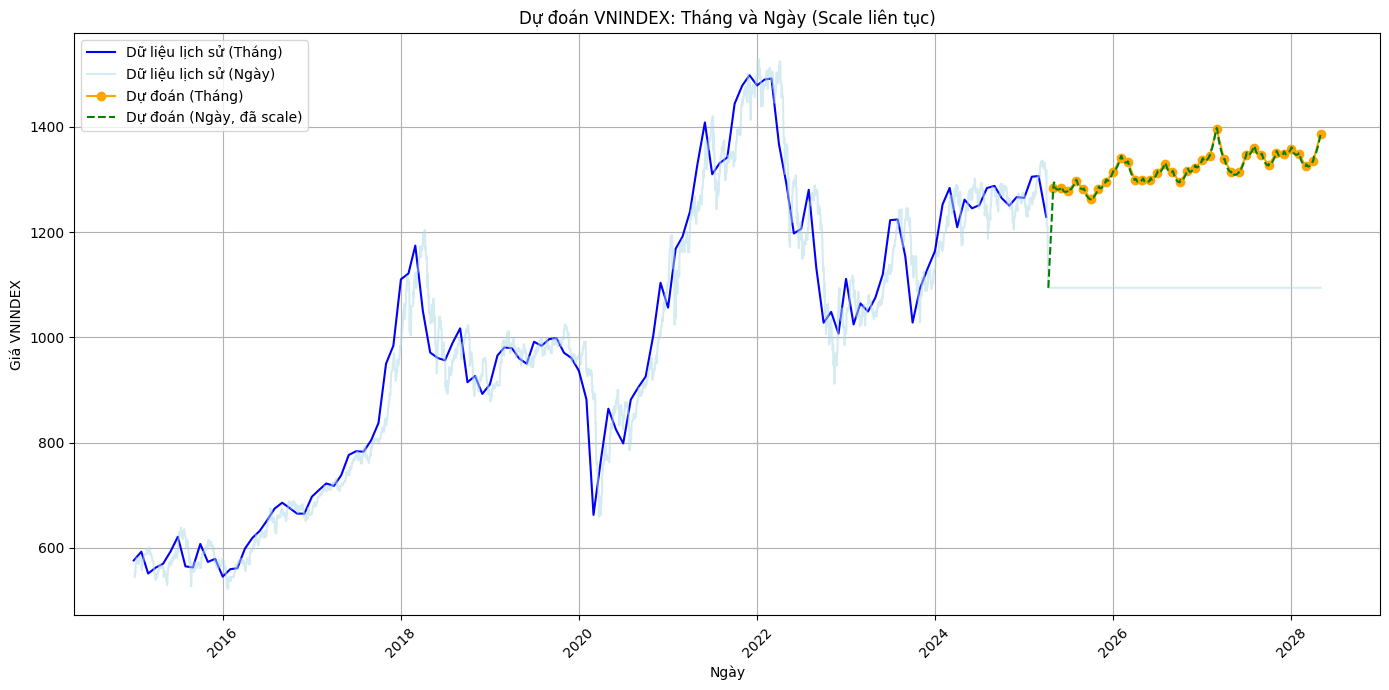

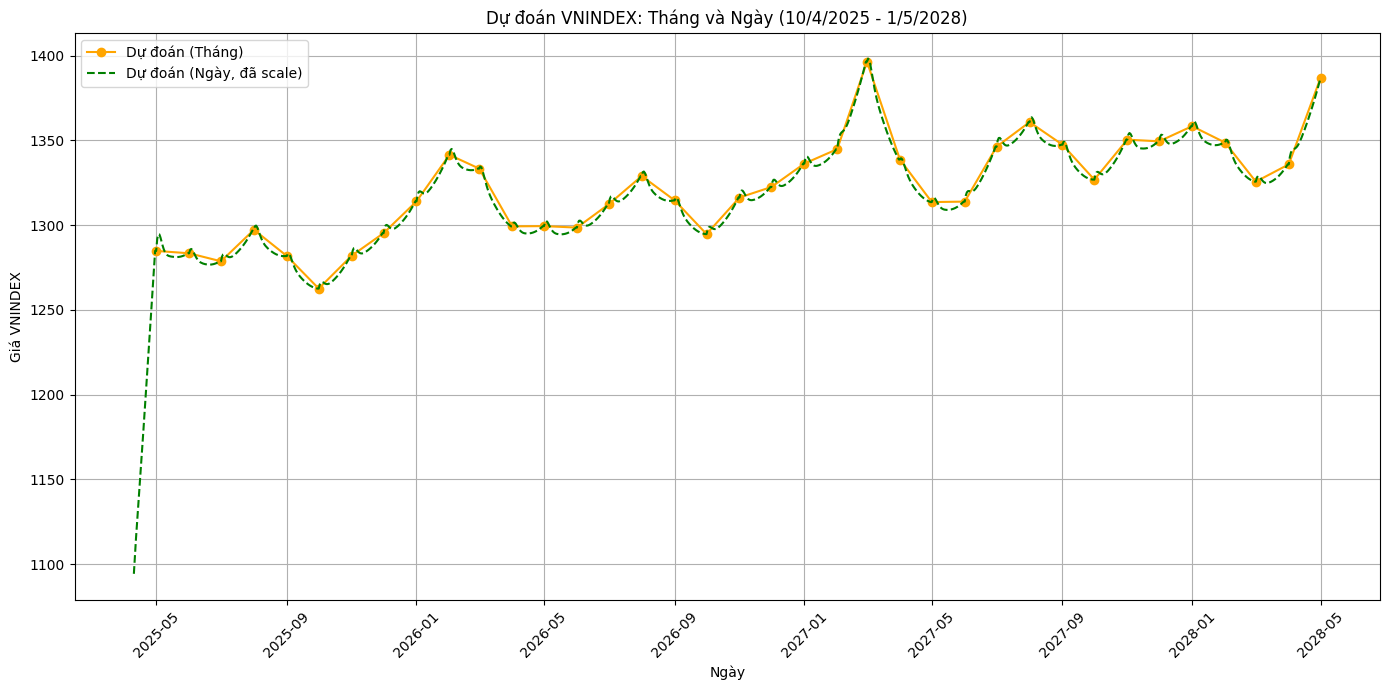

Biểu đồ tổng quan đã được lưu vào 'VNINDEX_Prediction_Chart_Full.png'
Biểu đồ chi tiết (10/4/2025 - 1/5/2028) đã được lưu vào 'VNINDEX_Prediction_Chart_Detail_2025_2028.png'


In [2]:
import pandas as pd
import numpy as np
from prophet import Prophet
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

data_month = pd.read_csv('VNINDEX_MONTH.csv')
data_month['Ngày'] = pd.to_datetime(data_month['Ngày'], format='%d/%m/%Y')
data_month = data_month[data_month['Ngày'] <= pd.to_datetime('2025-04-09')]
data_month = data_month[['Ngày', 'Lần cuối']]

# Xử lý định dạng số, loại bỏ dấu phẩy
data_month['Lần cuối'] = data_month['Lần cuối'].astype(str).str.replace(',', '').astype(float)
data_month.columns = ['ds', 'y']

# 2. Huấn luyện mô hình Prophet để dự đoán giá VNINDEX theo tháng
model_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model_prophet.fit(data_month)

# Tạo khung thời gian tương lai (từ 1/4/2024 đến 1/5/2028)
future_dates = pd.date_range(start='2024-04-01', end='2028-05-01', freq='MS')
future_df = pd.DataFrame({'ds': future_dates})
forecast = model_prophet.predict(future_df)
predicted_monthly = forecast[['ds', 'yhat']]
predicted_monthly.columns = ['Date', 'Predicted_Price']

# 3. Đọc và cắt dữ liệu ngày (VNINDEX_DAY.csv) đến 9/4/2025
data_day = pd.read_csv('VNINDEX_DAY.csv')
data_day['Ngày'] = pd.to_datetime(data_day['Ngày'], format='%d/%m/%Y')
data_day = data_day[data_day['Ngày'] <= pd.to_datetime('2025-04-09')]

# Tạo khung thời gian ngày từ 1/1/2015 đến 1/5/2028, điền giá trị thiếu
all_dates = pd.date_range(start='2015-01-01', end='2028-05-01', freq='D')
data_day = data_day.set_index('Ngày').reindex(all_dates).reset_index()
data_day = data_day.rename(columns={'index': 'Date'})

# Xử lý định dạng số, loại bỏ dấu phẩy
data_day['Lần cuối'] = data_day['Lần cuối'].astype(str).str.replace(',', '').astype(float)
data_day = data_day[['Date', 'Lần cuối']]
if data_day['Lần cuối'].isna().any():
    data_day['Lần cuối'] = data_day['Lần cuối'].fillna(method='ffill')

# Chuẩn hóa dữ liệu ngày
scaler = MinMaxScaler()
scaled_data_day = scaler.fit_transform(data_day['Lần cuối'].values.reshape(-1, 1))
if np.any(np.isnan(scaled_data_day)) or np.any(np.isinf(scaled_data_day)):
    scaled_data_day = np.nan_to_num(scaled_data_day, nan=0.0, posinf=0.0, neginf=0.0)

# 4. Chuẩn bị dữ liệu cho LSTM với time_step = 300
time_step = 300
def create_lstm_data(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

X, y = create_lstm_data(scaled_data_day, time_step)

# Toàn bộ dữ liệu từ 1/1/2015 đến 9/4/2025 dùng để huấn luyện
X_train_tensor = torch.FloatTensor(X).unsqueeze(-1)
y_train_tensor = torch.FloatTensor(y).reshape(-1, 1)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 5. Định nghĩa mô hình LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model_lstm = LSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_lstm = model_lstm.to(device)

num_epochs = 30
for epoch in range(num_epochs):
    model_lstm.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model_lstm(X_batch)
        loss = criterion(outputs, y_batch)
        optimizer.zero_grad()
        torch.nn.utils.clip_grad_norm_(model_lstm.parameters(), max_norm=1.0)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

# 6. Dự đoán từ 10/4/2025 đến 1/5/2028 với scale liên tục
# Khởi tạo dữ liệu ban đầu từ dữ liệu thực tế (1/1/2015 - 9/4/2025)
historical_data = scaled_data_day.flatten().tolist()

# Tạo khung thời gian dự đoán từ 10/4/2025 đến 1/5/2028
future_dates_daily = pd.date_range(start='2025-04-10', end='2028-05-01', freq='D')
daily_df = pd.DataFrame({'Date': future_dates_daily})
daily_df = daily_df.merge(predicted_monthly, on='Date', how='left')

# Dự đoán từng đoạn và scale liên tục
model_lstm.eval()
predictions_daily = []
current_window = historical_data[-time_step:]

# Lưu giá trị đã scale tại ngày trước đó để đảm bảo tính liên tục
last_scaled_price = scaler.inverse_transform([[historical_data[-1]]])[0, 0]

for i in range(len(predicted_monthly) - 1):
    start_date = max(predicted_monthly['Date'].iloc[i], pd.to_datetime('2025-04-10'))
    end_date = predicted_monthly['Date'].iloc[i + 1] - pd.Timedelta(days=1)
    next_month_start = predicted_monthly['Date'].iloc[i + 1]
    if i == len(predicted_monthly) - 2:
        end_date = pd.to_datetime('2028-05-01')

    if start_date > end_date:
        continue
    segment_dates = pd.date_range(start=start_date, end=end_date, freq='D')
    n_days = len(segment_dates)
    if n_days == 0:
        continue
    segment_predictions = []
    current_window_tensor = torch.FloatTensor(current_window[-time_step:]).unsqueeze(0).unsqueeze(-1).to(device)
    with torch.no_grad():
        window = current_window_tensor
        for _ in range(n_days):
            pred = model_lstm(window).cpu().numpy()[0, 0]
            segment_predictions.append(pred)
            new_window = np.append(window.cpu().numpy()[0, 1:, 0], pred)
            window = torch.FloatTensor(new_window).unsqueeze(0).unsqueeze(-1).to(device)
    segment_predictions = np.array(segment_predictions).reshape(-1, 1)
    segment_predictions_rescaled = scaler.inverse_transform(segment_predictions)

    # Scale giá ngày với nội suy tuyến tính để đảm bảo liên tục
    if end_date >= next_month_start - pd.Timedelta(days=1):
        monthly_price_next = predicted_monthly['Predicted_Price'].iloc[i + 1]
        daily_price_at_end = segment_predictions_rescaled[-1, 0]
        daily_price_at_start = segment_predictions_rescaled[0, 0]
        adjustment_at_start = last_scaled_price - daily_price_at_start
        adjustment_at_end = monthly_price_next - daily_price_at_end
        segment_length = n_days
        adjustments = np.linspace(adjustment_at_start, adjustment_at_end, segment_length)
        segment_predictions_scaled = segment_predictions_rescaled + adjustments.reshape(-1, 1)
        last_scaled_price = segment_predictions_scaled[-1, 0]
    else:
        adjustment_at_start = last_scaled_price - daily_price_at_start
        segment_predictions_scaled = segment_predictions_rescaled + adjustment_at_start
        last_scaled_price = segment_predictions_scaled[-1, 0]

    # Cập nhật current_window với giá đã scale
    scaled_segment = scaler.transform(segment_predictions_scaled.reshape(-1, 1)).flatten()
    current_window.extend(scaled_segment.tolist())

    # Lưu kết quả vào predictions_daily
    predictions_daily.extend(segment_predictions_scaled.flatten())

# Tạo DataFrame kết hợp dữ liệu lịch sử và dự đoán
combined_data = pd.concat([data_day[data_day['Date'] <= pd.to_datetime('2025-04-10')], 
                          pd.DataFrame({'Date': future_dates_daily, 'Lần cuối': predictions_daily})])
combined_data = combined_data[(combined_data['Date'] >= pd.to_datetime('2015-01-01')) & 
                              (combined_data['Date'] <= pd.to_datetime('2028-05-01'))]
combined_data = combined_data.reset_index(drop=True)

# Xóa dữ liệu thực tế từ 11/4/2025 đến 10/4/2025, giữ dự đoán từ 11/4/2025
combined_data = combined_data[~((combined_data['Date'] >= pd.to_datetime('2025-04-11')) & 
                                (combined_data['Date'] <= pd.to_datetime('2025-04-10')))]

# Lưu kết quả vào file CSV
combined_data.to_csv('VNINDEX_Full_Predictions_2015_2028.csv', index=False)
print("Dữ liệu đầy đủ từ 1/1/2015 đến 1/5/2028 đã được lưu vào 'VNINDEX_Full_Predictions_2015_2028.csv'")

# Biểu đồ tổng quan từ 1/1/2015 đến 1/5/2028
plt.figure(figsize=(14, 7))
plt.plot(data_month['ds'], data_month['y'], label='Dữ liệu lịch sử (Tháng)', color='blue')
plt.plot(data_day['Date'], data_day['Lần cuối'], label='Dữ liệu lịch sử (Ngày)', color='lightblue', alpha=0.5)

# Chỉ vẽ giá dự đoán tháng từ 10/4/2025 trở đi
predicted_monthly_filtered = predicted_monthly[predicted_monthly['Date'] >= pd.to_datetime('2025-04-10')]
plt.plot(predicted_monthly_filtered['Date'], predicted_monthly_filtered['Predicted_Price'], label='Dự đoán (Tháng)', color='orange', marker='o')

plt.plot(combined_data[combined_data['Date'] >= pd.to_datetime('2025-04-10')]['Date'], 
         combined_data[combined_data['Date'] >= pd.to_datetime('2025-04-10')]['Lần cuối'], 
         label='Dự đoán (Ngày, đã scale)', color='green', linestyle='--')
plt.title('Dự đoán VNINDEX: Tháng và Ngày (Scale liên tục)')
plt.xlabel('Ngày')
plt.ylabel('Giá VNINDEX')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('VNINDEX_Prediction_Chart_Full.png')
plt.show()
plt.close()

# Biểu đồ chi tiết từ 10/4/2025 đến 1/5/2028
mask_detail = (combined_data['Date'] >= pd.to_datetime('2025-04-10')) & (combined_data['Date'] <= pd.to_datetime('2028-05-01'))
combined_data_detail = combined_data[mask_detail]
month_df_detail = predicted_monthly[
    (predicted_monthly['Date'] >= pd.to_datetime('2025-04-10')) & 
    (predicted_monthly['Date'] <= pd.to_datetime('2028-05-01'))
]

plt.figure(figsize=(14, 7))
plt.plot(month_df_detail['Date'], month_df_detail['Predicted_Price'], label='Dự đoán (Tháng)', color='orange', marker='o')
plt.plot(combined_data_detail['Date'], combined_data_detail['Lần cuối'], label='Dự đoán (Ngày, đã scale)', color='green', linestyle='--')
plt.title('Dự đoán VNINDEX: Tháng và Ngày (10/4/2025 - 1/5/2028)')
plt.xlabel('Ngày')
plt.ylabel('Giá VNINDEX')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('VNINDEX_Prediction_Chart_Detail_2025_2028.png')
plt.show()
plt.close()

print("Biểu đồ tổng quan đã được lưu vào 'VNINDEX_Prediction_Chart_Full.png'")
print("Biểu đồ chi tiết (10/4/2025 - 1/5/2028) đã được lưu vào 'VNINDEX_Prediction_Chart_Detail_2025_2028.png'")